In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import utils as utils
# Set my plot theme
# See here for more detials
# https://github.com/RishiSadhir/rethinking2/blob/master/utils/plotting.py
#utils.set_theme()
COLOR = "#2A0933"

In [2]:
import arviz as az

In [3]:
%load_ext jupyterstan

# 6.3 - Collider Bias

`T->S<-N`

When you condition on a collider, it creates statistical association between its causes. We're going to load up McElreath's simulation from rethinking to show this. We'll examine the following causal model where M is the collider:

```
H -> M <- A
```

Even though there is no association between happiness and age, conditioning on marriage will make it look like there is.

**Python code 6.21 and Figure 6.4**

In [4]:
import rchitect as R

s = "rethinking::sim_happiness(seed=1977, N_years=1000);"
d = R.reval(s)
d = R.rcopy(d)
d = pd.DataFrame(d)
d.describe()

,age,married,happiness
count,1300.000000,1300.000000,1.300000e+03
mean,33.000000,0.300769,-8.335213e-17
std,18.768883,0.458769,1.214421e+00
min,1.000000,0.000000,-2.000000e+00
25%,17.000000,0.000000,-1.000000e+00
50%,33.000000,0.000000,-1.110223e-16
75%,49.000000,1.000000,1.000000e+00
max,65.000000,1.000000,2.000000e+00


Lets plot the raw simulation data

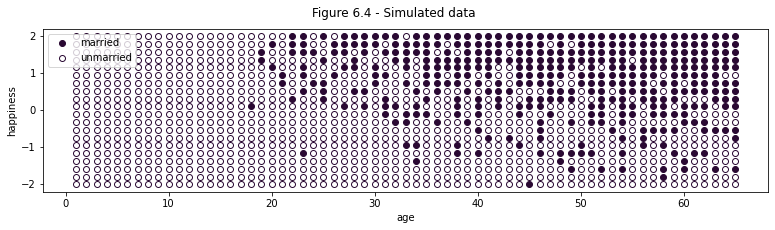

In [5]:
fig, ax = plt.subplots(figsize=(13,3))
ax.scatter(d[d.married==1]['age'], d[d.married==1]['happiness'], color = COLOR, label = "married")
ax.scatter(d[d.married==0]['age'], d[d.married==0]['happiness'], facecolor="white", color = COLOR, label = "unmarried")
ax.set_xlabel("age")
ax.set_ylabel("happiness")
ax.legend(loc = "upper left")
fig.suptitle("Figure 6.4 - Simulated data")
plt.show()

We're going to run the following model to study the relationship between age and happiness. We'll "control" for being married and see what happens.

First we prep the data in **Python code 6.22**

In [6]:
d2 = (d[d.age>17]
      .assign(A = lambda x: ((x.age-18)/(65-18)))
      .assign(mid = lambda x: x.married+1))
d_dict = {
    "N": len(d2.index),
    "N_mid": 2,
    "happiness": d2.happiness.values,
    "marriage_id": d2.mid.values.astype(np.int8),
    "age": d2.A
}
pd.DataFrame(d_dict).describe()

,N,N_mid,happiness,marriage_id,age
count,960.0,960.0,9.600000e+02,960.000000,960.000000
mean,960.0,2.0,-1.036208e-16,1.407292,0.500000
std,0.0,0.0,1.214587e+00,0.491586,0.294907
min,960.0,2.0,-2.000000e+00,1.000000,0.000000
25%,960.0,2.0,-1.000000e+00,1.000000,0.250000
50%,960.0,2.0,-1.110223e-16,1.000000,0.500000
75%,960.0,2.0,1.000000e+00,2.000000,0.750000
max,960.0,2.0,2.000000e+00,2.000000,1.000000


Here is what our model will look like. Consider the prior for $\beta$. The largest possible slope is $\frac{4}{1}$. 95% of mass is within 2 std deviations of the mean. So we'll use Normal(0,2) as our prior.

$$
happiness \sim normal(\mu_i, \sigma) \\
\mu_i = \alpha_{marriage\_id[i]} + \beta * age_i \\
\alpha \sim normal(0,1) \\
\beta \sim normal(0, 2)
$$



In [7]:
%%stan m6_9
data {
  int N;
  int N_mid;
  vector[N] happiness;
  int marriage_id[N];
  vector[N] age;
}
parameters {
  vector[N_mid] alpha;
  real beta1;
  real<lower=0> sigma;
}
model {
  alpha ~ normal(0, 1);
  beta1 ~ normal(0, 2);
  sigma ~ exponential(1);
  
  for (i in 1:N) {
    happiness[i] ~ normal(alpha[marriage_id[i]] + beta1*age[i], sigma);
  }
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m6_9_c608feefc09edcadf78a178de16a4088 NOW.


Creating pystan model & assigning it to variable name "m6_9".
Stan options:
 {'model_name': 'm6_9', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "m6_9"!
Compilation took 45 seconds.


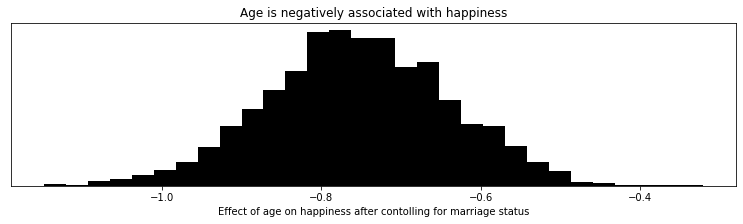

In [8]:
fit_m6_9 = m6_9.sampling(d_dict)
fig, ax = plt.subplots(figsize=(13,3))
ax.hist(fit_m6_9.extract()["beta1"], bins = 30, color = "black")
ax.set_yticks([])
ax.set_xlabel("Effect of age on happiness after contolling for marriage status")
ax.set_title("Age is negatively associated with happiness")
plt.show()

In [9]:
%%stan m6_10
data {
  int N;
  int N_mid;
  vector[N] happiness;
  int marriage_id[N];
  vector[N] age;
}
parameters {
  real alpha;
  real beta1;
  real<lower=0> sigma;
}
model {
  alpha ~ normal(0, 1);
  beta1 ~ normal(0, 2);
  sigma ~ exponential(1);
  
  for (i in 1:N) {
    happiness[i] ~ normal(alpha + beta1*age[i], sigma);
  }
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m6_10_856ddfbb569133673bae43d3dbc3dc4c NOW.


Creating pystan model & assigning it to variable name "m6_10".
Stan options:
 {'model_name': 'm6_10', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "m6_10"!
Compilation took 37 seconds.


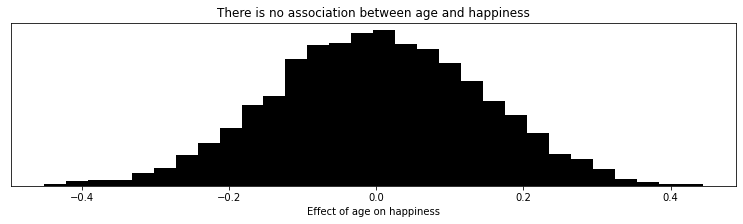

In [10]:
fit_m6_10 = m6_10.sampling(d_dict)
fig, ax = plt.subplots(figsize=(13,3))
ax.hist(fit_m6_10.extract()["beta1"], bins = 30, color = "black")
ax.set_yticks([])
ax.set_xlabel("Effect of age on happiness")
ax.set_title("There is no association between age and happiness")
plt.show()

Unboservables can create colliders. We'll simulate the following dag, where U is an observable and we are interested in the effects of G and P on C, to show this.
```
G->P
G->C
p->C
P<-U->C
```

Running the regression without U biases our estimates.

In [11]:
N = 200
# Make up some relationships
b_GP = 1
b_GC = 0
b_PC = 1
b_U = 2
#Play the dag forward
U = 2*stats.bernoulli.rvs(.5, size = N)-1
G = stats.norm.rvs(0, 1, size = N)
P = stats.norm.rvs(b_GP*G + b_U*U, 1)
C = stats.norm.rvs(b_PC*P + b_GC*G + b_U*U)
dlist = {
    "N":N,
    "U":U,
    "G":G,
    "P":P,
    "C":C
}

In [12]:
%%stan m6_11
data {
  int N;
  int U[N];
  vector[N] G;
  vector[N] P;
  vector[N] C;
}
parameters {
  real a;
  real b_PC;
  real b_GC;
  real<lower=0> sigma;
}
model {
  vector[N] mu;
  a ~ normal(0, 1);
  b_PC ~ normal(0, 1);
  b_GC ~ normal(0, 1);
  mu = a + b_PC*P + b_GC*G;
  C ~ normal(mu, sigma);
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m6_11_b50b9962adda5b57e46cf853c7b3b59a NOW.


Creating pystan model & assigning it to variable name "m6_11".
Stan options:
 {'model_name': 'm6_11', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "m6_11"!
Compilation took 37 seconds.


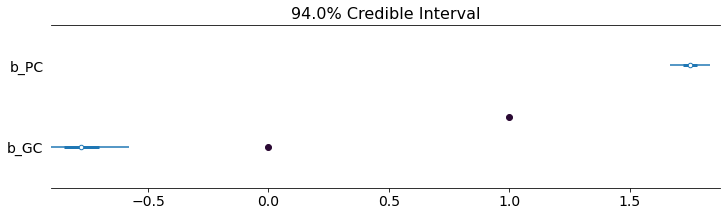

In [13]:
fit_6_11 = m6_11.sampling(dlist)
fig, ax = plt.subplots(figsize=(12, 3))
az.plot_forest(fit_6_11.extract(['b_PC', 'b_GC']), ax=ax)
ax.scatter(b_GC, "b_GC", color=COLOR)
ax.scatter(b_PC, "b_PC", color=COLOR)
plt.show()

In [14]:
%%stan m6_12
data {
  int N;
  vector[N] U;
  vector[N] G;
  vector[N] P;
  vector[N] C;
}
parameters {
  real a;
  real b_PC;
  real b_GC;
  real b_U;
  real<lower=0> sigma;
}
model {
  vector[N] mu;
  a ~ normal(0, 1);
  b_PC ~ normal(0, 1);
  b_GC ~ normal(0, 1);
  b_U ~ normal(0, 1);
  mu = a + b_PC*P + b_GC*G + b_U*U;
  C ~ normal(mu, sigma);
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m6_12_13c8349c0e4c96ea797a23d3c6b6e443 NOW.


Creating pystan model & assigning it to variable name "m6_12".
Stan options:
 {'model_name': 'm6_12', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "m6_12"!
Compilation took 38 seconds.


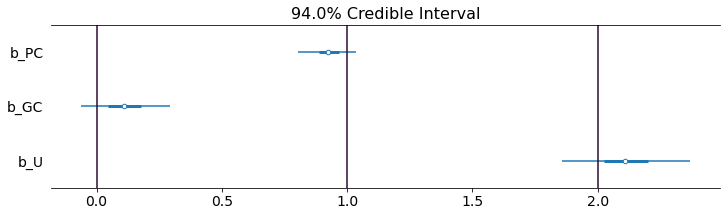

In [15]:
fit_6_12 = m6_12.sampling(dlist)
fig, ax = plt.subplots(figsize=(12, 3))
az.plot_forest(fit_6_12.extract(['b_PC', 'b_GC', 'b_U']), ax=ax)
ax.axvline(b_GC,color=COLOR)
ax.axvline(b_PC,color=COLOR)
ax.axvline(b_U, color=COLOR)
plt.show()

Including the variation in C that comes from G and P zaps the variation that comes from them. Whats left? The variation from U. If I already know P, what does G tell us? Well, within a given P, the difference in G screams the effect of U. The following plot shows us this.

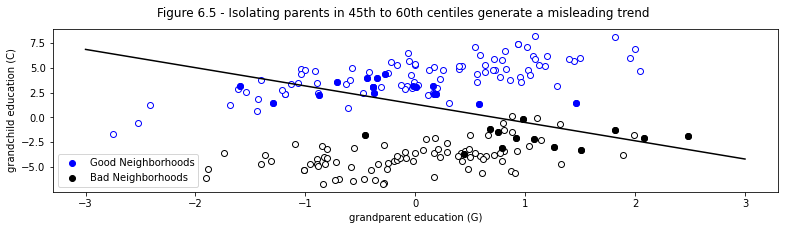

In [16]:
q = np.quantile(P, [.45, .6])
ps = np.logical_and(P>q[0],  P<q[1])
psg = np.logical_and(ps, U==1)
psb = np.logical_and(ps, U==-1)
xseq = np.linspace(-3, 3, 1000)
mod = np.polyfit(G[ps], C[ps], 1)

fig, ax = plt.subplots(figsize=(13,3))
ax.scatter(G[U==-1], C[U==-1], facecolor="white", color = "black")
ax.scatter(G[U==1], C[U==1], facecolor="white", color = "blue")
ax.scatter(G[psg], C[psg], color = "blue", label = "Good Neighborhoods")
ax.scatter(G[psb], C[psb], color = "black", label = "Bad Neighborhoods")
predict = np.poly1d(mod)
ax.plot(xseq, predict(xseq), color = "black")
ax.set_xlabel("grandparent education (G)")
ax.set_ylabel("grandchild education (C)")
fig.suptitle("Figure 6.5 - Isolating parents in 45th to 60th centiles generate a misleading trend")
ax.legend()
plt.show()

# 6.4 - Confronting Confounding